In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.8.2'

In [7]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from PIL import Image
import numpy as np

from IPython import display

In [8]:
#Wczytanie zdjęć treningowych (
images_train = []
labels_train = []
size = 70

for i in range(1,size+1):
    im = Image.open('../../Inz/mnist/Praca_inz/Zdjecia/Baza_zdjec_konwersja_64x64/s1/'+str(i)+'.png')
    arr_im = np.array(im)
    arr_im = (arr_im - 127.5) / 127.5  # Normalize the images to [-1, 1]
    images_train.append(arr_im)
    labels_train.append(0) 

for j in range(1,size+1):
    im = Image.open('../../Inz/mnist/Praca_inz/Zdjecia/Baza_zdjec_konwersja_64x64/s2/'+str(i)+'.png')
    arr_im = np.array(im)
    arr_im = (arr_im - 127.5) / 127.5  # Normalize the images to [-1, 1]
    images_train.append(arr_im)
    labels_train.append(1) 
print(len(images_train))

140


In [9]:
BUFFER_SIZE = 70
BATCH_SIZE = 256

In [14]:
# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(images_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



# Tworzymy zestaw danych zawierający obrazy i etykiety
train_dataset_with_labels = tf.data.Dataset.from_tensor_slices((images_train, labels_train))

# Tasujemy i dzielimy dane na partie
train_dataset = train_dataset_with_labels.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():

    # Wejście dla wektora losowych liczb (latent vector)
    input_latent = tf.keras.Input(shape=(100,))

    # Wejście dla etykiety
    input_label = tf.keras.Input(shape=(1,))

    merged_input = layers.concatenate([input_latent, input_label], axis=1)

    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

In [8]:
def make_discriminator_model():

    inputs = tf.keras.Input(shape=(100,))
    labels = tf.keras.Input(shape=(1,))  # Dodajemy wejście dla etykiet
    
    # Łączymy etykiety z danymi wejściowymi
    concatenated_inputs = layers.concatenate([inputs, labels], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
generator = make_generator_model()


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 1

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    #generate_and_save_images(generator,
    #                         epoch + 1,
    #                         seed)

    # Save the model every 2000 epochs
    if (epoch + 1) % 200 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)


  input_data = [seed, 0]

  generate_and_save_images(generator,
                           epochs,
                           input_data)

In [22]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    prediction = model(test_input, training=False)

    plt.figure()
    plt.imshow(prediction[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    plt.savefig('./img/imssagde_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

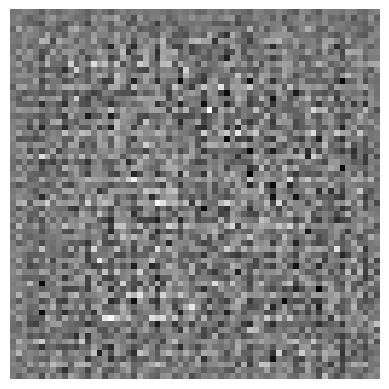

Time for epoch 1 is 5.87675404548645 sec


KeyboardInterrupt: 

In [20]:
train(train_dataset, EPOCHS)